In [1]:
from functools import partial

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button

import chugunov_indicator as chug
from chugunov_indicator.default_data import DefaultScreeningData

In [2]:
def D_T_setup(ax) -> None:
    """Sets up the axes of a D-T graph."""

    ax.set_xlabel("$T$")
    ax.set_ylabel("$\\rho$")

    ax.set_xscale("log")
    ax.set_yscale("log")

def D_T_colorgraph(T, D, y, fig, ax) -> tuple:
    """Creates a colormesh of y-data on a D-T graph."""

    D_T_setup(ax)

    cb = ax.pcolormesh(T, D, y)
    cbar = fig.colorbar(cb)

    return cb, cbar

def clip(x: np.ndarray, maximum: float = 1.01) -> np.ndarray:
    return np.where(x > maximum, maximum, x)

In [3]:
starting_kwargs = {
    "abar": 4.028776983649795,
    "z2bar": 4.12949645671095,
    "z1": 2,
    "z2": 6
}

fixed_kwargs = {
    "zbar": 2,
    "a1": 4,
    "a2": 12
}

In `2. fitting.ipynb`, a fitting procedure was developed that, for fixed $\bar{A}, \overline{Z^2}, Z_1, Z_2$ and arbitrary $\bar{Z}, A_1, A_2$, takes screening factor data on an $n \times n$ D-T grid and computes the negative $y$-intercept of the border curve using simple algebra.

The task now is to pre-compute each value of $c$ for many different values of $\xi := (\bar{A}, \overline{Z^2}, Z_1, Z_2)$ on an $m \times m \times m \times m$ grid. This grid can then be used to create an interpolator via `scipy.interpolate.RegularGridInterpolator`, which can then be used to predict the screening function for any possible $\xi$ that falls within that grid.

In `default_data.py`, we take `m = 20` and `n = 35`, as shown below. As $\overline{Z^2}$ can take a wide range of values, we interpolate in terms of $\log_{10}{\overline{Z^2}}$ to keep things uniform.

In [4]:
{k: v.shape for k, v in DefaultScreeningData.grids.items()}

{'abar': (20, 1, 1, 1, 1, 1),
 'log_z2bar': (1, 20, 1, 1, 1, 1),
 'z1': (1, 1, 20, 1, 1, 1),
 'z2': (1, 1, 1, 20, 1, 1),
 'log_T': (1, 1, 1, 1, 35, 1),
 'log_D': (1, 1, 1, 1, 1, 35)}

In [5]:
interp = DefaultScreeningData.default_interpolator
skip_screening = partial(chug.skip_screening, interpolator=interp)

To determine how well this interpolator works, we can modify the interactive plot from `2. fitting.ipynb` to show the actual and interpolated values of $c$.

In [6]:
D_, T_ = np.logspace([7, 9.35], [-4, 8], num=100).T
T, D = np.meshgrid(T_, D_)
log_T, log_D = np.log10(T), np.log10(D)

In [7]:
F = chug.chugunov_2009.chugunov_2009(T=T, D=D, **starting_kwargs, **fixed_kwargs)

0

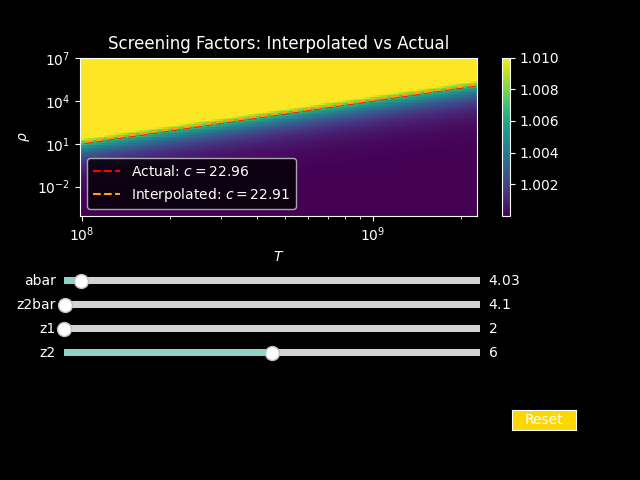

In [8]:
%matplotlib widget

fig1, ax1 = plt.subplots()
fig1.subplots_adjust(bottom=0.55)

ax1.set_title("Screening Factors: Interpolated vs Actual")

# Slider dictionaries
ax_sliders = {}
sliders = {}
maxes = {
    "abar": 52.43965444432472,
    "z2bar": 1000,
    "z1": 10,
    "z2": 10
}

# Create initial plots
c = 22.96
cb, cbar = D_T_colorgraph(T, D, clip(F), fig1, ax1)

actual, = ax1.plot(T_, 1/10**c * T_**3, linestyle="--", color="red")
actual.set_label(f"Actual: $c = {c:.2f}$")

c_interp = 22.97
interpolate, = ax1.plot(T_, 1/10**c_interp * T_**3, linestyle="--", color="orange")
interpolate.set_label(f"Interpolated: $c = {c_interp:.2f}$")

ax1.legend()

# Create function to be called when slider value is changed
def update(val) -> None:
    kwargs_new = {key: sliders[key].val for key in maxes}
    F_new = chug.chugunov_2009.chugunov_2009(T, D, **kwargs_new, **fixed_kwargs)
    cb.set_array(clip(F_new))

    border_new = (1.005 < F_new) & (F_new < 1.01)
    log_T_border, log_D_border = log_T[border_new], log_D[border_new]
    
    diff = 3*log_T_border - log_D_border
    c_actual = np.mean(diff)
    
    actual.set_ydata(1/10**c_actual * T_**3)
    actual.set_label(f"Actual: $c = {c_actual:.2f}$")
    
    xi = np.array([*kwargs_new.values()])
    xi[1] = np.log10(xi[1])

    c_interp = interp(xi).item()
    interpolate.set_ydata(1/10**c_interp * T_**3)
    interpolate.set_label(f"Interpolated: $c = {c_interp:.2f}$")

    ax1.legend()

for j, key in enumerate(maxes):
    # Create axes
    ax_sliders[key] = fig1.add_axes([0.1, 0.4 - j*0.05, 0.65, 0.03])
    # Create sliders
    sliders[key] = Slider(ax_sliders[key], key, 2, maxes[key], valinit=starting_kwargs[key])
    # Call update function when slider value is changed
    sliders[key].on_changed(update)

# Create axes for reset button and create button
resetax = fig1.add_axes([0.8, 0.105, 0.1, 0.04])
button = Button(resetax, 'Reset', color='gold',
                hovercolor='skyblue')
 
# Create a function resetSlider to set slider to
# initial values when Reset button is clicked
 
def resetSlider(event) -> None:
    for slider in sliders.values():
        slider.reset()
 
# Call resetSlider function when clicked on reset button
button.on_clicked(resetSlider)

# Show graph
#fig1.show()

Tinkering with the sliders above reveals that $c_{\mathrm{interp}}$ is almost always within $0.05$ of $c_{\mathrm{actual}}$, and is virtually always within $0.1$ of it.